In [1]:
from data_gen import NetworkDatasetFactory

import torch
import torch_geometric
import numpy as np
import osmnx as ox
import networkx as nx

from IPython.display import IFrame
import typing
import glob
import os

In [2]:
class NetworkDataset(torch_geometric.data.Dataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
    
    @property
    def file_names(self):
        return glob.glob('data/*')
    
    def len(self):
        return len(self.file_names)

    def get(self, idx):
        data = torch.load(os.path.join(self.root, f'data_{idx}.pt'))
        data.x = data.x.type(torch.float32)
        data.edge_attr = data.edge_attr.type(torch.float32)
        return data

In [3]:
normalize_features = torch_geometric.transforms.NormalizeFeatures(['edge_attr'])
# transforms = torch_geometric.transforms.Compose([normalize_features])
# dataset = NetworkDataset('data', transform=normalize_features)
dataset = NetworkDataset('data')
loader = torch_geometric.loader.DataLoader(dataset)

In [4]:
class Stage1Model(torch.nn.Module):
    '''
        Propagates graph data to current node and neighbors
    '''
    def __init__(self, out_embedding_dim):
        super().__init__()
        
        nn1 = torch.nn.Sequential(
            torch.nn.Linear(dataset.num_edge_features, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, dataset.num_node_features*64),
            torch.nn.ReLU()
        )
        # conv1 gets edge information into the nodes
        self.conv1 = torch_geometric.nn.conv.NNConv(dataset.num_node_features, 64, nn1)
        # conv2 and conv3 work on the nodes only
        self.conv2 = torch_geometric.nn.conv.GCNConv(64, 128)
        self.conv3 = torch_geometric.nn.conv.GCNConv(128, 64)
        self.attn = torch_geometric.nn.conv.GATv2Conv(64, out_embedding_dim, heads=3, concat=False)
        
        
        
    def forward(self, network_graph):
        x, edge_index, edge_attr = network_graph.x, network_graph.edge_index, network_graph.edge_attr
        x = self.conv1(x, edge_index, edge_attr)
        x = self.conv2(x, edge_index)        
        x = self.conv3(x, edge_index)        
        out = self.attn(x, edge_index)
        return out
    
test = Stage1Model(32)
test(dataset[0])

tensor([[ 0.0304,  0.0509, -0.0100,  ...,  0.0022, -0.0256,  0.0153],
        [ 0.0304,  0.0509, -0.0100,  ...,  0.0022, -0.0256,  0.0153],
        [ 0.0304,  0.0509, -0.0100,  ...,  0.0022, -0.0256,  0.0153],
        ...,
        [ 0.0304,  0.0509, -0.0100,  ...,  0.0022, -0.0256,  0.0153],
        [ 0.0304,  0.0509, -0.0100,  ...,  0.0022, -0.0256,  0.0153],
        [ 0.0304,  0.0509, -0.0100,  ...,  0.0022, -0.0256,  0.0153]],
       grad_fn=<AddBackward0>)

In [5]:
class PreferenceEmbedder(torch.nn.Module):
    '''
        Embeds a (n_preferences, 1) user preference vector to a (embedding_dim, 1) vector
    '''
    def __init__(self, n_preferences, embedding_dim):
        super().__init__()
        self.fclayer = torch.nn.Linear(n_preferences, embedding_dim)
        self.relu = torch.nn.ReLU()
    
    def forward(self, user_preferences):
        x = self.fclayer(user_preferences)
        x = self.relu(x)
        return x
    
data = dataset[0]
test = PreferenceEmbedder(data.y.shape[0], 10)
test(data.y)

tensor([ 8.4047,  0.0000,  9.6319,  0.0000, 13.3729,  0.0000, 57.3690, 69.8578,
         0.0000,  0.0000], grad_fn=<ReluBackward0>)

In [6]:
class Stage2Model(torch.nn.Module):
    '''
        Does final computations on available node choices and returns finalized choice scores
    '''
    def __init__(self, out_embedding_dim):
        super().__init__()
        self.conv1 = torch_geometric.nn.dense.DenseGCNConv(in_channels=-1, 
                                                out_channels=64)
        self.conv2 = torch_geometric.nn.dense.DenseGCNConv(in_channels=64, 
                                                out_channels=64)
        self.attn = torch_geometric.nn.dense.DenseGATConv(64, out_embedding_dim, heads=3, concat=False)
    
        self.softmax = torch.nn.Softmax(dim=1)
        
    def forward(self, network_graph):
        x, adj = network_graph.x, network_graph.adj
        x = self.conv1(x, adj)
        x = self.conv2(x, adj)
        x = self.attn(x, adj)
        
        x = torch.sum(x, dim=-1)
        scores = self.softmax(x)
        return scores

In [7]:
class CustomGraphModel(torch.nn.Module):
    '''
        Stage 1 blocks -> mask/delete -> +preference embeddings -> stage 2 blocks -> out
    '''
    def __init__(self, Stage1Model, PreferenceEmbedder, Stage2Model):
        super().__init__()
        self.Stage1Model = Stage1Model
        self.PreferenceEmbedder = PreferenceEmbedder
        self.Stage2Model = Stage2Model
    
    # creates a new graph with all nodes that are connected to the current node.
    def get_neighbor_graph(self, network_graph, network_graph_propagated):
        current_node_index = torch.squeeze(torch.nonzero(network_graph.x[:, -1]==1))
        coo_indices_top = torch.nonzero(network_graph.edge_index[0]==current_node_index)[0]
        coo_indices_bottom = torch.nonzero(network_graph.edge_index[1]==current_node_index)[0]
        neighbors_1 = network_graph_propagated.edge_index[1][coo_indices_top]
        neighbors_2 = network_graph_propagated.edge_index[0][coo_indices_bottom]
        
        indices = torch.unique(torch.cat((neighbors_1, neighbors_2)))
        # remove current_node_index from indices if present
        indices = indices[indices!=current_node_index]
        current_node_neighbors = torch.index_select(network_graph_propagated.x, 0, indices)
        # adjacency tensor will be all ones to denote fully connected
        s = current_node_neighbors.shape[0]
        adj = torch.ones((s, s))
        
        neighbor_graph = torch_geometric.data.Data(x=current_node_neighbors, adj=adj)
        return neighbor_graph
    
    def forward(self, network_graph, user_preferences):
        original_graph = torch_geometric.data.Data(x=network_graph.x, edge_index=network_graph.edge_index)
        embedded_x = self.Stage1Model(network_graph)
        network_graph_propagated = network_graph
        network_graph_propagated.x = embedded_x
        
        neighbor_graph = self.get_neighbor_graph(original_graph, network_graph_propagated)
        user_preferences_embedded = self.PreferenceEmbedder(user_preferences)
        neighbor_graph.x = torch.add(neighbor_graph.x, user_preferences_embedded)
        neighbor_graph_with_task_information = neighbor_graph
        
        out = self.Stage2Model(neighbor_graph_with_task_information)
        return out

stage_1_node_embedding_dim = 32
stage_2_node_embedding_dim = 32

stage1model = Stage1Model(stage_1_node_embedding_dim)
preference_embedder = PreferenceEmbedder(data.y.shape[0], stage_1_node_embedding_dim)
stage2model = Stage2Model(stage_2_node_embedding_dim)
model = CustomGraphModel(stage1model, preference_embedder, stage2model)
# for d in dataset:
#     model(d, d.y)
model(dataset[50], dataset[50].y)

tensor([[0.5000, 0.5000]], grad_fn=<SoftmaxBackward0>)

In [30]:
class GraphEnv:
    def __init__(self):
        pass
    
    def setup_env_for_episode(self, plottable_graph, network_graph, user_preferences):
        '''
            Defines neccesary class variables for an episode. These variables are used for internal
            or for graphing purposes.
        '''
        self.plottable_graph = plottable_graph
        self.network_graph = network_graph
        self.user_preferences = user_preferences
        self.user_preference_overall_distance = user_preferences[0]
        self.user_preference_steepness = user_preferences[1]
        self.user_preference_surface_roughness = user_preferences[2]
        
        self.num_nodes = self.network_graph.x.shape[0]
        self.num_steps = 0
        
        is_start_node_index = 0
        current_node_index = torch.squeeze(torch.nonzero(self.network_graph.x[:, is_start_node_index]==1))
        self.nodes_in_route_indices = [int(current_node_index.numpy())]
    
    def step(self, action):
        '''
            Changes the environment based on an action. The action is the index of
            which node the model choose for the route to go through next. The network graph
            is changed to update the current node, give the reward, check if episode done, etc.
        '''
        self.nodes_in_route_indices.append(int(action.numpy()))
        is_end_node_index = 1
        is_in_route_index = 2
        is_current_node_index = 3
        terminated = False
        truncated = False
        observation = None
        info = None
        
        action_is_end_node = self.network_graph.x[action, is_end_node_index] == 1
        if action_is_end_node:
            terminated = True
            
        if self.num_steps >= self.num_nodes:
            truncated = True
        
        # action is idx of next chosen node (new current node)
        prev_current_node_index = torch.squeeze(torch.nonzero(self.network_graph.x[:, is_current_node_index]==1))
        # update previous current node
        self.network_graph.x[prev_current_node_index, is_current_node_index] = 0
        # update new current node
        trail_already_in_route = int(self.network_graph.x[action, is_in_route_index] == 1)
        self.network_graph.x[action, is_current_node_index] = 1
        self.network_graph.x[action, is_in_route_index] = 1
        
        
        # get reward
        reward = None
        very_steep_grade = 25
        num_surface_types_minus_one = 2
        edge_distance_attr_index = 0
        edge_surface_roughness_attr_index = 1
        edge_steepness_attr_index = 2
        if action_is_end_node:
            # give total reward
            nodes_in_route_indices = torch.nonzero(self.network_graph.x[is_in_route_index] == 1)
            route_subgraph = self.network_graph.subgraph(nodes_in_route_indices)
            edges_in_route = route_subgraph.edge_attr
            
            overall_distance_pr = 1 - abs(1 - (torch.sum(edges_in_route[:, edge_distance_attr_index]/self.user_preference_overall_distance)))
            steepness_pr = 1 - abs((self.user_preference_steepness/100) - (torch.mean(edges_in_route[:, edge_steepness_attr_index]/very_steep_grade)))
            surface_roughness_pr = 1 - abs((self.user_preference_surface_roughness/100) - (torch.mean(edges_in_route[:, edge_surface_roughness_attr_index]/num_surface_types_minus_one)))
            
            reward = torch.mean(torch.tensor([overall_distance_pr, steepness_pr, surface_roughness_pr])) * 100
        else:
            # give intermediate reward
            previous_current_node = self.network_graph.x[prev_current_node_index]
            new_current_node = self.network_graph.x[action]
            
            connecting_edge_index = torch.squeeze(torch.nonzero(((self.network_graph.edge_index[0]==prev_current_node_index)&(self.network_graph.edge_index[1]==action))))
            connecting_edge = self.network_graph.edge_attr[connecting_edge_index]
            
            overall_distance_pr = 1 - abs(1 - (connecting_edge[edge_distance_attr_index]/self.user_preference_overall_distance))
            steepness_pr = 1 - abs((self.user_preference_steepness/100) - (connecting_edge[edge_steepness_attr_index]/very_steep_grade))
            surface_roughness_pr = 1 - abs((self.user_preference_surface_roughness/100) - (connecting_edge[edge_surface_roughness_attr_index]/num_surface_types_minus_one))
            reward = torch.mean(torch.tensor([overall_distance_pr, steepness_pr, surface_roughness_pr])) - trail_already_in_route
    
            
        observation = self.network_graph
        info = {}
        return observation, reward, terminated, truncated, info
        
    def reset(self):
        '''
            Resets the environment for a new episode by resetting all class variables
            and generating a new network graph.
        '''
        plottable_graph, random_network_graph = NetworkDatasetFactory().get_random_pyg_graph()
        random_network_graph.x = random_network_graph.x.type(torch.float32)
        random_network_graph.edge_attr = random_network_graph.edge_attr.type(torch.float32)
        self.setup_env_for_episode(plottable_graph, random_network_graph, random_network_graph.y)
        return self.network_graph, {}
        

In [31]:
def get_model(stage_1_node_embedding_dim, stage_2_node_embedding_dim):
        stage1model = Stage1Model(stage_1_node_embedding_dim)
        preference_embedder = PreferenceEmbedder(3, stage_1_node_embedding_dim)
        stage2model = Stage2Model(stage_2_node_embedding_dim)
        model = CustomGraphModel(stage1model, preference_embedder, stage2model)
        return model
    
class Agent:
    def __init__(self, model):
        self.learning_rate = 1e-4
        self.model = model
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate)
        self.rewards = []
        
    def sample_action(self, observation):
        '''Returns an action based on the policy and observation'''
        
        clone = observation.clone()
        neighbor_scores = model(clone, clone.y)
        top_neighbor_index = torch.argmax(neighbor_scores)
        # FOR TESTING
        top_neighbor_index = torch.randint(0, neighbor_scores.shape[-1], (1,))[0]
        # need to figure out what node idx this is in terms of the entire graph
        current_node_index = torch.squeeze(torch.nonzero(observation.x[:, -1]==1))
        coo_indices_top = torch.nonzero(observation.edge_index[0]==current_node_index)[0]
        coo_indices_bottom = torch.nonzero(observation.edge_index[1]==current_node_index)[0]
        neighbors_1 = observation.edge_index[1][coo_indices_top]
        neighbors_2 = observation.edge_index[0][coo_indices_bottom]
        neighbor_indices = torch.unique(torch.cat((neighbors_1, neighbors_2)))
        
        top_index = neighbor_indices[top_neighbor_index]
        top_action = top_index
        return top_action
    
    def update(self):
        '''Updates the policy network's weights.'''
        # this is where the algorithm specifics come in...
        pass
        

In [32]:
env = GraphEnv()
observation, info = env.reset()
agent = Agent(get_model(32, 32))

def sample_and_step(observation):
    action = agent.sample_action(observation)
    obs, reward, terminated, truncated, info = env.step(action)
    return obs
    
o1 = sample_and_step(observation)
o2 = sample_and_step(o1)
o3 = sample_and_step(o2)
o4 = sample_and_step(o3)
o5 = sample_and_step(o4)
o6 = sample_and_step(o5)
o7 = sample_and_step(o6)
o8 = sample_and_step(o7)
o9 = sample_and_step(o8)
o10 = sample_and_step(o9)
o11 = sample_and_step(o10)
o12 = sample_and_step(o11)
o13 = sample_and_step(o12)

In [33]:
print(env.nodes_in_route_indices)

[387, 388, 376, 240, 376, 240, 376, 240, 376, 240, 376, 240, 376, 240]


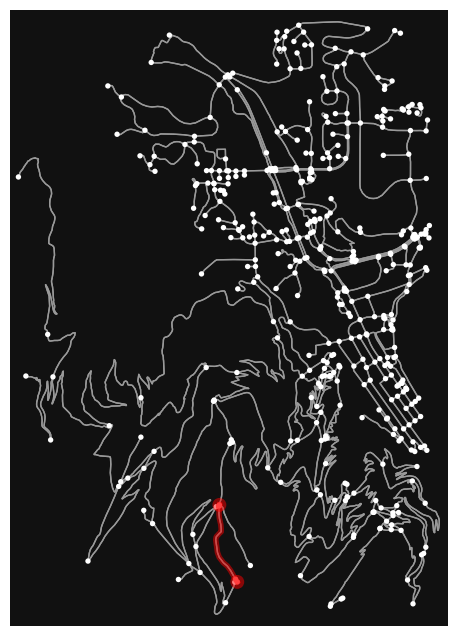

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [34]:
node_list = list(env.plottable_graph.nodes())
ox.plot_graph_route(env.plottable_graph, [node_list[i] for i in env.nodes_in_route_indices])

## Rendering

In [ ]:
G, pyG = NetworkDatasetFactory().get_random_pyg_graph()

In [ ]:
node_list = list(G.nodes())

In [ ]:
origin_node = list(G.nodes())[0]
destination_node = list(G.nodes())[-1]
route = nx.shortest_path(G, origin_node, destination_node)
ox.plot_graph_route(G, route)

In [ ]:
env = GraphEnv()

for seed in [1, 2, 3, 5, 8]:  # Fibonacci seeds
    # set seed
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    # Reinitialize agent every seed
    agent = Agent(get_model(32, 32))
    reward_over_episodes = []

    for episode in range(total_num_episodes):
        observation, info = env.reset()
        
        done = False
        while not done:
            action = agent.sample_action(observation)

            obs, reward, terminated, truncated, info = env.step(action)
            agent.rewards.append(reward)

            done = terminated or truncated
           
        # TODO
        reward_over_episodes.append(wrapped_env.return_queue[-1])
        agent.update()
        
        if episode % 1000 == 0:
            # TODO
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)

In [ ]:
# Plot rewards